In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn import tree

In [2]:
# 1. Dataset: température et vent → choix entre Veste ou t-shirt (plus réaliste)
np.random.seed(42)
n_samples = 200

# Température entre -5°C et 40°C, vent entre 0 et 60 km/h
temperatures = np.random.normal(18, 12, n_samples)  # Distribution normale centrée sur 18°C
temperatures = np.clip(temperatures, -5, 40)  # Limiter les valeurs extrêmes

vents = np.random.exponential(15, n_samples)  # Distribution exponentielle pour le vent
vents = np.clip(vents, 0, 60)

# Règles plus complexes et moins parfaites pour le choix du vêtement
vetements = []
for temp, vent in zip(temperatures, vents):
    # Base de décision avec du bruit
    score = temp * 0.7 - vent * 0.2 + np.random.normal(0, 3)  # Ajout de bruit
    
    # Zones de décision floues
    if score < 8:
        vetement = 'Veste'
    elif score > 18:
        vetement = 't-shirt'
    else:
        # Zone d'incertitude - décision aléatoire pondérée
        prob_veste = max(0.1, min(0.9, (18 - score) / 10))
        vetement = 'Veste' if np.random.random() < prob_veste else 't-shirt'
    
    vetements.append(vetement)

# Créer le DataFrame avec valeurs manquantes
df = pd.DataFrame({'temperature': temperatures, 'vent': vents, 'vetement': vetements})

# Introduire 5% de valeurs manquantes aléatoirement
missing_mask_temp = np.random.random(n_samples) < 0.05
missing_mask_vent = np.random.random(n_samples) < 0.05

df.loc[missing_mask_temp, 'temperature'] = np.nan
df.loc[missing_mask_vent, 'vent'] = np.nan

print(f"Dataset: {len(df)} exemples")
print(f"Valeurs manquantes - Température: {df['temperature'].isna().sum()}")
print(f"Valeurs manquantes - Vent: {df['vent'].isna().sum()}")
print("Distribution des vêtements:")
print(df['vetement'].value_counts())
df.head(10)

Dataset: 200 exemples
Valeurs manquantes - Température: 13
Valeurs manquantes - Vent: 10
Distribution des vêtements:
vetement
Veste      131
t-shirt     69
Name: count, dtype: int64


,temperature,vent,vetement
0,23.960570,31.479130,Veste
1,16.340828,20.250514,Veste
2,25.772262,17.911116,Veste
3,36.276358,18.184313,t-shirt
4,15.190160,6.682385,Veste
5,15.190357,5.213431,Veste
6,36.950554,24.860618,t-shirt
7,27.209217,24.919923,t-shirt
8,12.366307,30.269251,Veste
9,24.510721,36.669239,t-shirt


In [3]:
# 2. Séparation et entraînement
X = df[['temperature', 'vent']]
Y = df['vetement']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


In [4]:
# 3. Creation du modele
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, Y_train)

print(f"Train: {X_train.shape}")

Train: (140, 2)


In [5]:
# 4. Évaluation
Y_pred = clf.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)

print(f"Précision: {accuracy:.2%}\n")
print(classification_report(Y_test, Y_pred))

Précision: 78.33%

              precision    recall  f1-score   support

       Veste       0.86      0.79      0.83        39
     t-shirt       0.67      0.76      0.71        21

    accuracy                           0.78        60
   macro avg       0.76      0.78      0.77        60
weighted avg       0.79      0.78      0.79        60



In [6]:
# 5. Test sur exemples fictifs
exemples = pd.DataFrame([
    [5, 40],    # Froid et venteux
    [30, 10],   # Chaud et calme
    [20, 25],   # Zone ambiguë
    [15, 35],   # Venteux
], columns=['temperature', 'vent'])

predictions = clf.predict(exemples)
for i, pred in enumerate(predictions):
    print(f"Temp={exemples.iloc[i]['temperature']}°C, Vent={exemples.iloc[i]['vent']}km/h → {pred}")

Temp=5°C, Vent=40km/h → Veste
Temp=30°C, Vent=10km/h → t-shirt
Temp=20°C, Vent=25km/h → Veste
Temp=15°C, Vent=35km/h → Veste


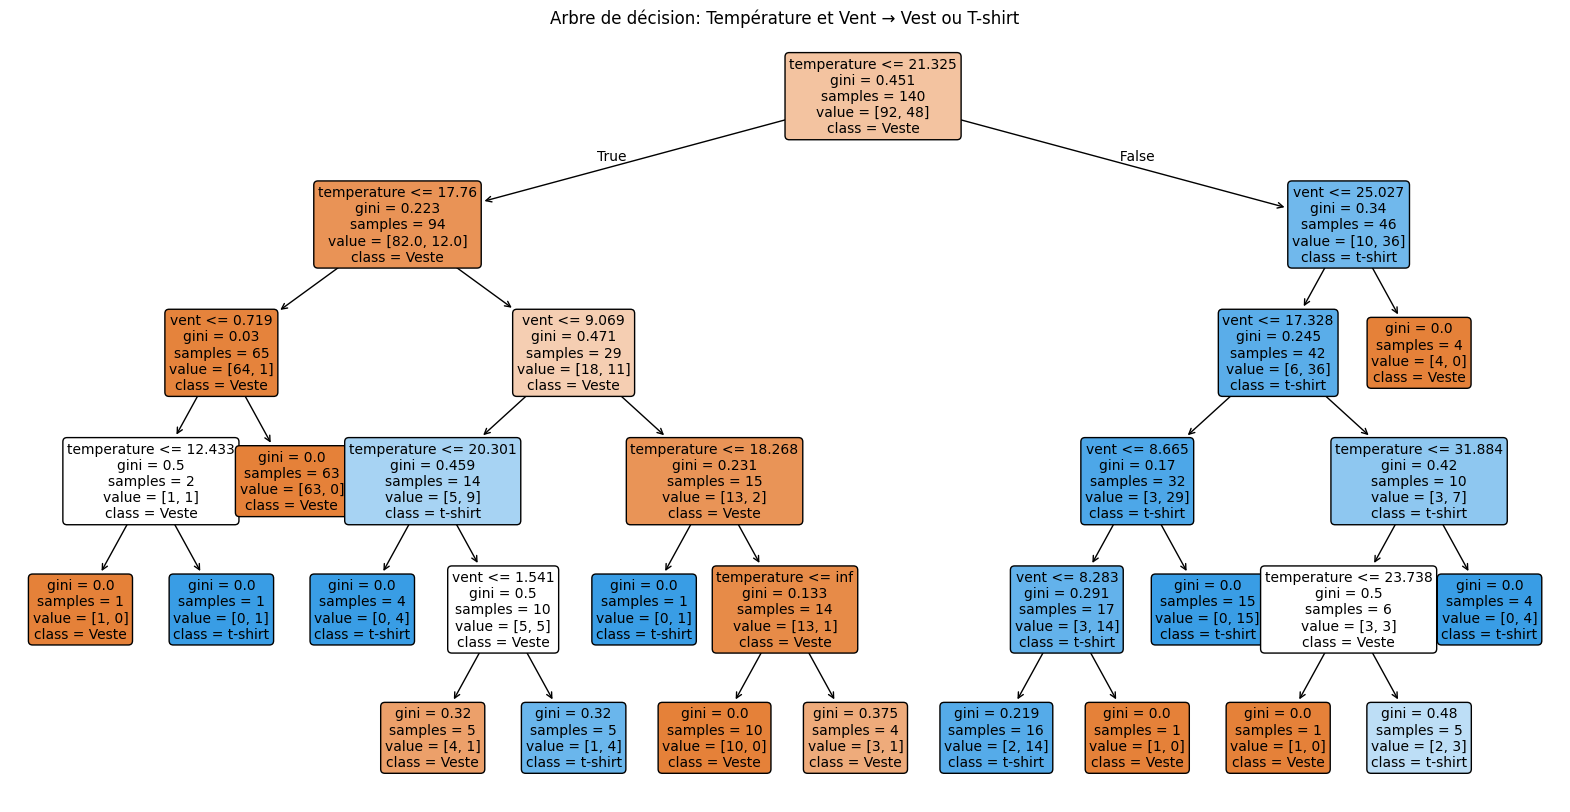

In [7]:
# 5. Visualisation de l'arbre de décision
plt.figure(figsize=(20, 10))
tree.plot_tree(clf, feature_names=X.columns, class_names=clf.classes_, filled=True, rounded=True, fontsize=10)
plt.title("Arbre de décision: Température et Vent → Vest ou T-shirt")
plt.show()

Random Forest - Précision: 78.33%
Gradient Boosting - Précision: 75.00%
XGBoost - Précision: 78.33%


/home/thomas/Bureau/Spe-IA/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


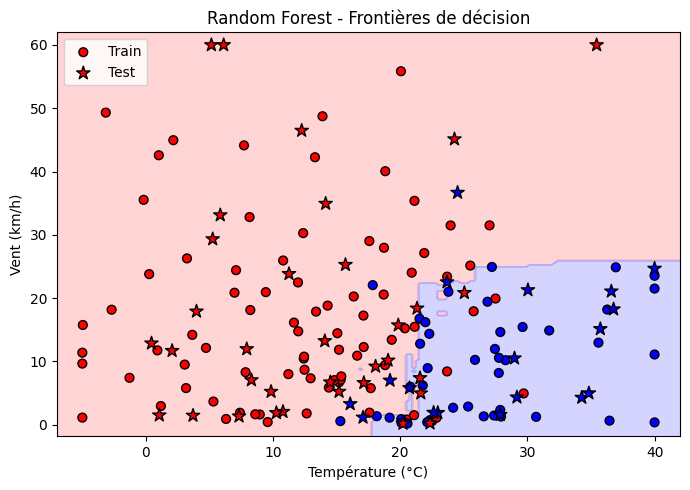

/home/thomas/Bureau/Spe-IA/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


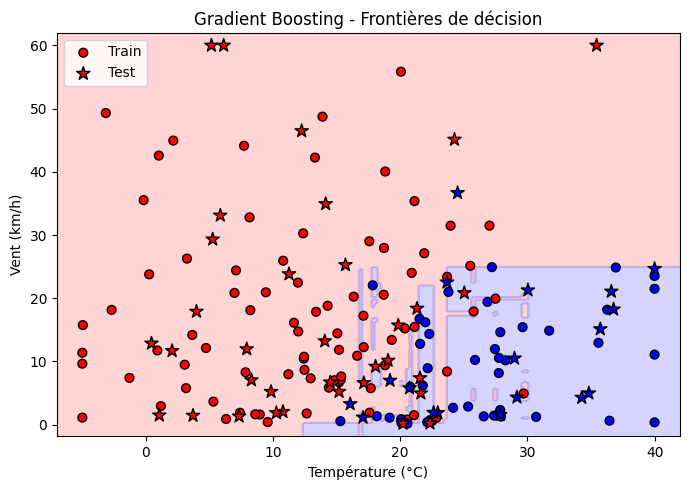

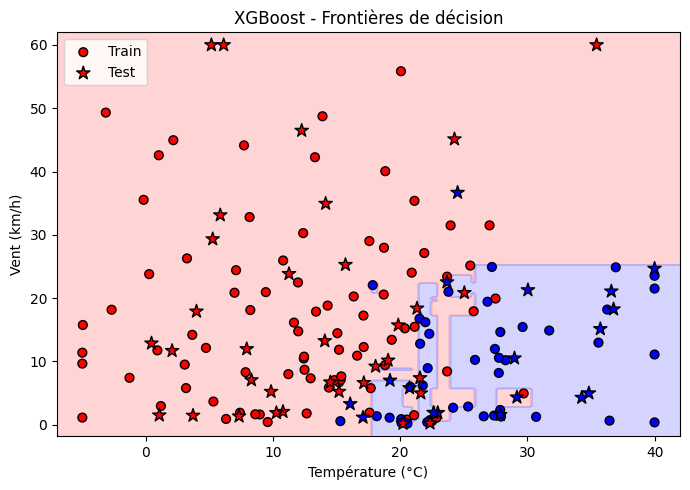

In [8]:
# 6. Comparaison de modèles : Random Forest, Gradient Boosting, XGBoost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.impute import SimpleImputer

# Encode labels for XGBoost
le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)
Y_test_encoded = le.transform(Y_test)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss', random_state=42)
}

# First, handle missing values in the training and test data
imputer_models = SimpleImputer(strategy='mean')
X_train_clean = imputer_models.fit_transform(X_train)
X_test_clean = imputer_models.transform(X_test)

# Fit all models and store predictions
for name, model in models.items():
    if name == 'XGBoost':
        model.fit(X_train_clean, Y_train_encoded)
        Y_pred_encoded = model.predict(X_test_clean)
        Y_pred = le.inverse_transform(Y_pred_encoded)
    else:
        model.fit(X_train_clean, Y_train)
        Y_pred = model.predict(X_test_clean)
    
    acc = accuracy_score(Y_test, Y_pred)
    print(f"{name} - Précision: {acc:.2%}")
    models[name] = model  # update with fitted model

# Grid for decision boundary
x_min, x_max = X['temperature'].min() - 2, X['temperature'].max() + 2
y_min, y_max = X['vent'].min() - 2, X['vent'].max() + 2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_df = pd.DataFrame(grid, columns=['temperature', 'vent'])

cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

for name, model in models.items():
    if name == 'XGBoost':
        Z = model.predict(grid_df)
        Z_mapped = np.array([le.inverse_transform([pred])[0] for pred in Z])
        Z_numeric = np.array([0 if label == 'Veste' else 1 for label in Z_mapped])
    else:
        Z = model.predict(grid_df)
        Z_numeric = np.array([0 if label == 'Veste' else 1 for label in Z])
    
    Z_numeric = Z_numeric.reshape(xx.shape)
    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z_numeric, cmap=cmap_light, alpha=0.5)
    # Training points
    plt.scatter(X_train['temperature'], X_train['vent'], c=Y_train.map({'Veste':0, 't-shirt':1}), cmap=cmap_bold, edgecolor='k', s=40, label='Train')
    # Test points
    plt.scatter(X_test['temperature'], X_test['vent'], c=Y_test.map({'Veste':0, 't-shirt':1}), cmap=cmap_bold, edgecolor='k', s=100, marker='*', label='Test')
    plt.xlabel('Température (°C)')
    plt.ylabel('Vent (km/h)')
    plt.title(f"{name} - Frontières de décision")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
# 7. Test des modèles avec valeurs manquantes dans le dataset
from sklearn.impute import SimpleImputer

# Ajout de valeurs manquantes aléatoires dans X
X_missing = X.copy()
mask = np.random.rand(*X_missing.shape) < 0.1  # 10% de valeurs manquantes
X_missing[mask] = np.nan

# Séparation train/test sur ce nouveau jeu
X_train_m, X_test_m, Y_train_m, Y_test_m = train_test_split(X_missing, Y, test_size=0.3, random_state=42)

# Imputation simple (moyenne) pour chaque modèle
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train_m)
X_test_imp = imputer.transform(X_test_m)

# Réentraîner et tester chaque modèle
for name, model in models.items():
    if name == 'XGBoost':
        model.fit(X_train_imp, Y_train_m.map({'Veste':0, 't-shirt':1}))
        Y_pred_encoded = model.predict(X_test_imp)
        Y_pred = np.where(Y_pred_encoded == 0, 'Veste', 't-shirt')
    else:
        model.fit(X_train_imp, Y_train_m)
        Y_pred = model.predict(X_test_imp)
    acc = accuracy_score(Y_test_m, Y_pred)
    print(f"{name} (valeurs manquantes) - Précision: {acc:.2%}")

Random Forest (valeurs manquantes) - Précision: 71.67%
Gradient Boosting (valeurs manquantes) - Précision: 68.33%
XGBoost (valeurs manquantes) - Précision: 66.67%


/home/thomas/Bureau/Spe-IA/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


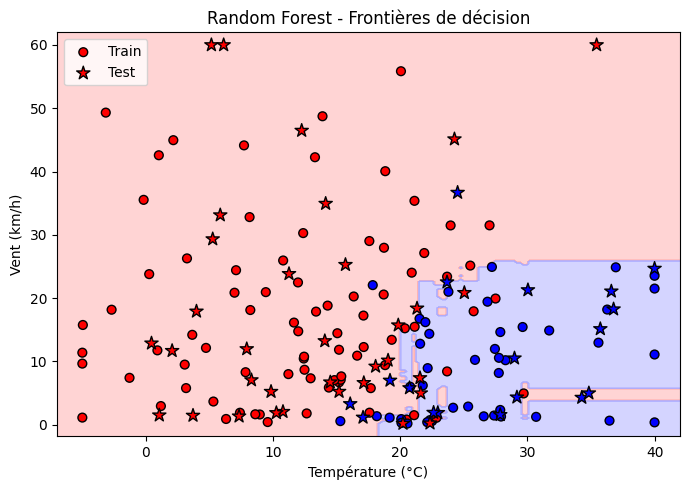

/home/thomas/Bureau/Spe-IA/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


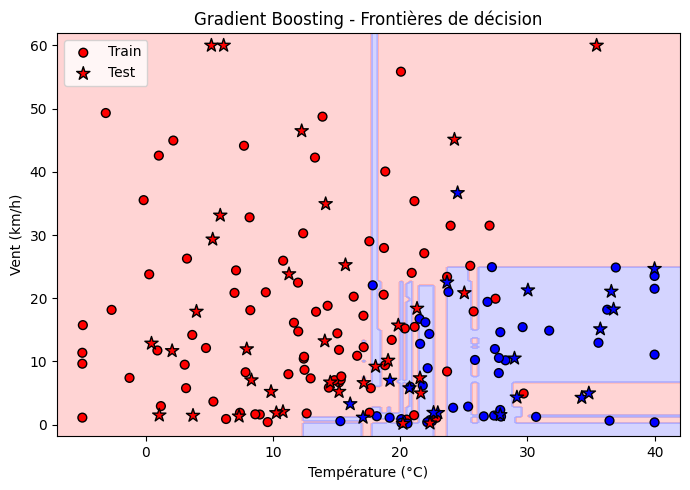

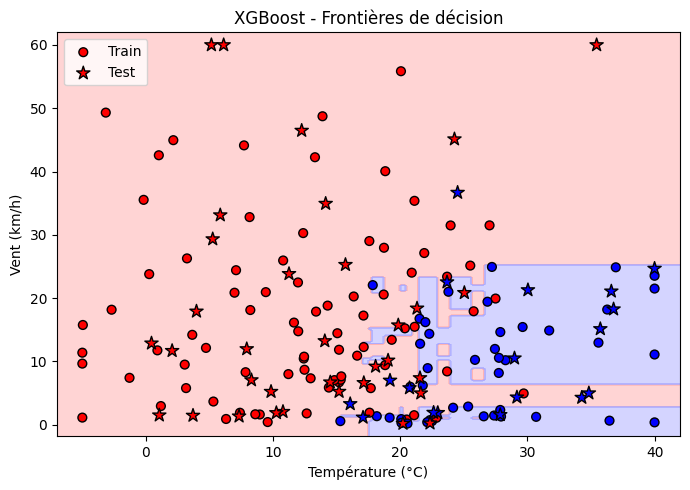

In [10]:
# Grid for decision boundary
x_min, x_max = X['temperature'].min() - 2, X['temperature'].max() + 2
y_min, y_max = X['vent'].min() - 2, X['vent'].max() + 2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_df = pd.DataFrame(grid, columns=['temperature', 'vent'])

cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

for name, model in models.items():
    if name == 'XGBoost':
        Z = model.predict(grid_df)
        Z_mapped = np.array([le.inverse_transform([pred])[0] for pred in Z])
        Z_numeric = np.array([0 if label == 'Veste' else 1 for label in Z_mapped])
    else:
        Z = model.predict(grid_df)
        Z_numeric = np.array([0 if label == 'Veste' else 1 for label in Z])
    
    Z_numeric = Z_numeric.reshape(xx.shape)
    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z_numeric, cmap=cmap_light, alpha=0.5)
    # Training points
    plt.scatter(X_train['temperature'], X_train['vent'], c=Y_train.map({'Veste':0, 't-shirt':1}), cmap=cmap_bold, edgecolor='k', s=40, label='Train')
    # Test points
    plt.scatter(X_test['temperature'], X_test['vent'], c=Y_test.map({'Veste':0, 't-shirt':1}), cmap=cmap_bold, edgecolor='k', s=100, marker='*', label='Test')
    plt.xlabel('Température (°C)')
    plt.ylabel('Vent (km/h)')
    plt.title(f"{name} - Frontières de décision")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
# Optimisation des hyperparamètres pour XGBoost
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Traiter les valeurs manquantes d'abord
imputer = SimpleImputer(strategy='mean')
X_train_clean = imputer.fit_transform(X_train)
X_test_clean = imputer.transform(X_test)

# Encoder les labels pour XGBoost
le = LabelEncoder()
Y_train_encoded = le.fit_transform(Y_train)
Y_test_encoded = le.transform(Y_test)

# Grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# GridSearch avec validation croisée
print("Recherche des meilleurs hyperparamètres pour XGBoost...")
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_clean, Y_train_encoded)

# Meilleurs paramètres
print(f"\nMeilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score CV: {grid_search.best_score_:.4f}")

# Test avec le meilleur modèle
best_xgb = grid_search.best_estimator_
Y_pred_encoded = best_xgb.predict(X_test_clean)
Y_pred = le.inverse_transform(Y_pred_encoded)
best_accuracy = accuracy_score(Y_test, Y_pred)

print(f"\nPrécision sur test avec meilleurs paramètres: {best_accuracy:.4f}")
print(f"Amélioration par rapport au modèle de base: {best_accuracy - 0.85:.4f}")  # Remplacer par score de base

# Afficher les 5 meilleures combinaisons
print("\nTop 5 des meilleures combinaisons:")
results = grid_search.cv_results_
indices = np.argsort(results['mean_test_score'])[::-1][:5]
for i, idx in enumerate(indices):
    print(f"{i+1}. Score: {results['mean_test_score'][idx]:.4f}, Params: {results['params'][idx]}")

Recherche des meilleurs hyperparamètres pour XGBoost...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits



Meilleurs paramètres: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
Meilleur score CV: 0.8357

Précision sur test avec meilleurs paramètres: 0.7667
Amélioration par rapport au modèle de base: -0.0833

Top 5 des meilleures combinaisons:
1. Score: 0.8357, Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
2. Score: 0.8357, Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
3. Score: 0.8357, Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
4. Score: 0.8357, Params: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
5. Score: 0.8357, Params: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1.0}
